# Newtork Tour of mice genetics

In [34]:
import glob
import numpy as np
import pandas as pd
from utils import *
from matplotlib import pyplot as plt

#Graph
import networkx as nx
from pygsp import graphs, learning

#Scipy
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

#Sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import matthews_corrcoef as mc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2

#Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Torch
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


### Loading the data

In [35]:
DATA_DIR = "../../Data/"

In [36]:
pheno = pd.read_csv(DATA_DIR+'Phenotype.txt', sep="\t", index_col="PhenoID")
pheno.head()

,B6D2F1,D2B6F1,C57BL.6J,DBA.2J,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
PhenoID,,,,,,,,,,,,,,,,,,,,,
X3063,NaN,NaN,1254.090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,707.929,1481.930,NaN,577.571,1971.000,NaN
X3352,NaN,NaN,724.205,NaN,NaN,NaN,NaN,700.643,1304.79,NaN,...,NaN,NaN,NaN,NaN,525.393,765.048,NaN,579.286,691.286,NaN
X1093,NaN,NaN,887.500,507.40,NaN,NaN,NaN,NaN,NaN,NaN,...,366.5,NaN,NaN,NaN,472.640,1060.340,1032.26,646.000,978.000,NaN
X2256,NaN,NaN,607.708,460.07,NaN,NaN,NaN,NaN,NaN,NaN,...,236.4,NaN,NaN,NaN,426.500,788.400,965.60,563.900,1272.400,NaN
X830,NaN,NaN,35444.000,25325.00,NaN,NaN,NaN,NaN,NaN,NaN,...,21515.0,NaN,NaN,NaN,21898.000,38538.000,36348.00,26982.000,39328.000,NaN


In [37]:
mapBXD = pd.read_csv(DATA_DIR+'map_BXD.txt', sep="\t", index_col="SNP")
mapBXD.head()

,Chr,Pos
SNP,,
rs31443144,1,3.010274
rs6269442,1,3.492195
rs32285189,1,3.511204
rs258367496,1,3.659804
rs32430919,1,3.777023


In [38]:
phenoID = pd.read_csv(DATA_DIR+'Phenotypes_id_aligner.txt', sep="\t", index_col = "PhenoID", encoding = "ISO-8859-1")
phenoID.head()

,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,Quantitive.trait,Tissues,Diet,Strains
PhenoID,,,,,,,,,,,,,,,,
X3063,3063,12890,"Central nervous system, metabolism, behavior: ...","Activity of 13-week old females, total counts ...",Activity,1.0,1.0,"Central nervous system, metabolism, behavior: ...","Central nervous system, metabolism, behavior: ...","Andreux P, Williams EG, Koutnikova H, Houtkoop...",Auwerx_1,Activity of 13-week old females,Yes,muscle,NaN,19
X3352,3352,12960,"Central nervous system, metabolism, behavior: ...","Activity of 13-week old males, total counts of...",Activity,2.0,1.0,"Central nervous system, metabolism, behavior: ...","Central nervous system, metabolism, behavior: ...","Andreux P, Williams EG, Koutnikova H, Houtkoop...",Auwerx_1,Activity of 13-week old males,Yes,muscle,NaN,30
X1093,1093,15698,"Metabolism, behavior: Activity (ambulations) a...","Activity (ambulations) at night, metabolic cag...",Activity,3.0,1.0,"Metabolism, behavior: Activity (ambulations) a...",Trait_137_AUW-BXD,"Williams EG, Andreux P, Houtkooper R, Auwerx J",Auwerx_2,Activty (ambulations)_night_CD_AUC,Yes,muscle,NaN,42
X2256,2256,15699,"Metabolism, behavior: Activity (ambulations) a...","Activity (ambulations) at night, metabolic cag...",Activity,4.0,1.0,"Metabolism, behavior: Activity (ambulations) a...",Trait_138_AUW-BXD,"Williams EG, Andreux P, Houtkooper R, Auwerx J",Auwerx_2,Activty (ambulations)_night_HFD_AUC,Yes,muscle,HFD,40
X830,830,17629,"Metabolism, behavior: Activity (movement) at d...","Activity (movement) at dark phase (night) _CD,...",Activity,5.0,1.0,"Metabolism, behavior: Activity (movement) at d...","Metabolism, behavior: Activity (movement) at d...","Williams EG, Wu Y, Jha P, Dubuis S, Amariuta T...",Auwerx_2,Activity (movement) at_night_CD [AUC],Yes,muscle,NaN,45


In [39]:
geno = pd.read_csv(DATA_DIR+'Genotype_BXD.txt', sep="\t", index_col=["SNP"])
geno.head()

,B6D2F1,D2B6F1,C57BL.6J,DBA.2J,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
SNP,,,,,,,,,,,,,,,,,,,,,
rs31443144,0,0,-1,1,-1,-1,1,1,1,-1,...,-1,1,-1,1,1,-1,-1,-1,-1,-1
rs6269442,0,0,-1,1,-1,-1,1,1,1,-1,...,-1,1,-1,1,1,-1,-1,-1,-1,-1
rs32285189,0,0,-1,1,-1,-1,1,1,1,-1,...,-1,1,-1,1,1,-1,-1,-1,-1,-1
rs258367496,0,0,-1,1,-1,-1,1,1,1,-1,...,-1,1,-1,1,1,-1,-1,-1,-1,-1
rs32430919,0,0,-1,1,-1,-1,1,1,1,-1,...,-1,1,-1,1,1,-1,-1,-1,-1,-1


In [40]:
filenames = glob.glob(DATA_DIR+"expression data" + "/*.txt")

dfs = [pd.read_csv(f, sep="\t") for f in filenames]

expression = pd.concat(dfs, ignore_index=True, sort=False)

In [41]:
expression = expression.set_index(["gene"])
expression.head()

,C57BL.6J,DBA.2J,BXD68,BXD43,BXD44,BXD45,BXD48,BXD49,BXD50,BXD51,...,BXD54,BXD59,BXD72,BXD76,BXD78,BXD86,BXD88,BXD91,BXD93,BXD94
gene,,,,,,,,,,,,,,,,,,,,,
Nmt1_10338077,11.150,11.440,11.280,11.702,11.654,11.404,11.453,11.169,11.652,11.492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Psmb5_10338095,12.906,13.125,13.144,13.099,13.071,13.048,12.825,12.993,12.915,13.142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hdac5_10338098,9.060,9.563,9.059,9.425,9.245,8.998,8.836,9.120,9.343,9.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dlg1_10338109,7.226,6.781,3.735,5.143,4.652,7.637,8.119,7.908,7.954,8.832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wars_10338116,10.601,10.554,10.742,10.298,10.520,10.795,10.247,10.807,10.572,10.366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Exploration

In [9]:
pheno.shape, phenoID.shape,expression.shape,mapBXD.shape,geno.shape

((5092, 97), (5092, 16), (1214846, 97), (7324, 2), (7324, 97))

In [10]:
phenoID["Category"].unique()

array(['Activity', 'Anxiety', 'Drug response', 'Hematology', 'Immune',
       'Metabolism', 'Metabolites', 'Microbiome', 'Morphology',
       'Musculoskeletal', 'Nervous system', 'Other'], dtype=object)

In [11]:
phenoID[phenoID["Shown_pheno"].str.contains("body weight")].shape

(120, 16)

### Graphs construction

<div class="alert alert-block alert-info"> <b> Gene Expression Levels </b> Nodes: mice, edges: correlation between mice expression levels for eye's genes. </div>

In [4]:
expressionEye = pd.read_csv(DATA_DIR+"expression data" + "/EYE.txt", sep="\t", index_col=["gene"])
expressionEye = expressionEye.iloc[:,:]

In [5]:
expressionEye = expressionEye.astype("float32")
expressionEye

,B6D2F1,C57BL.6J,DBA.2J,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,...,BXD86,BXD87,BXD89,BXD90,BXD65b,BXD48a,BXD65a,BXD98,BXD99,D2B6F1
gene,,,,,,,,,,,,,,,,,,,,,
Copg_1415670_at,9.790,9.917,9.690,9.852,9.920,9.657,9.793,9.828,9.544,9.728,...,9.732,9.916,9.670,9.894,9.834,9.792,9.827,9.578,9.855,9.762
Atp6v0d1_1415671_at,12.184,12.133,12.148,12.088,12.104,12.227,12.063,12.204,11.847,12.131,...,12.224,12.118,12.092,12.125,12.133,12.052,12.215,12.226,12.299,12.138
Golga7_1415672_at,12.116,12.104,12.108,12.068,12.084,12.062,12.170,12.039,12.305,12.056,...,11.969,12.170,12.188,12.048,12.054,12.125,12.150,11.908,12.009,12.145
Psph_1415673_at,9.003,9.187,9.192,8.952,9.128,8.942,9.041,9.066,9.239,9.124,...,9.117,9.211,9.099,8.846,9.120,9.035,9.334,8.578,9.342,8.981
Trappc4_1415674_a_at,10.790,10.763,10.749,10.815,10.784,10.762,10.743,10.522,10.560,10.725,...,10.932,10.534,10.584,10.578,10.874,10.825,10.678,10.626,10.790,10.738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tfrc_AFFX-TransRecMur-X57349_5_at,6.854,6.834,6.387,6.293,6.863,6.175,6.190,6.095,6.256,6.078,...,6.678,6.441,5.998,7.262,6.859,7.009,6.632,6.232,6.226,6.752
Tfrc_AFFX-TransRecMur-X57349_M_at,6.446,6.395,6.180,6.052,6.147,6.077,5.968,5.831,5.882,5.890,...,6.267,6.116,5.711,6.730,6.411,6.454,6.222,5.992,6.192,6.368
AFFX-TrpnX-3_AFFX-TrpnX-3_at,5.085,5.067,5.116,5.120,5.152,5.198,5.100,5.096,5.050,5.266,...,5.217,5.104,5.100,5.121,5.118,5.147,5.246,5.094,5.098,5.104


In [6]:
expressionEye = expressionEye.reset_index(drop=True).transpose()
expressionEye

,0,1,2,3,4,5,6,7,8,9,...,45070,45071,45072,45073,45074,45075,45076,45077,45078,45079
B6D2F1,9.790,12.184,12.116,9.003,10.790,10.265,12.152,10.914,11.704,12.212,...,13.752,6.281,5.410,5.146,8.744,6.854,6.446,5.085,5.366,5.166
C57BL.6J,9.917,12.133,12.104,9.187,10.763,10.271,12.169,10.950,11.728,12.300,...,13.678,6.303,5.437,5.099,8.785,6.834,6.395,5.067,5.338,5.210
DBA.2J,9.690,12.148,12.108,9.192,10.749,10.243,12.116,10.995,12.015,12.194,...,13.586,6.332,5.530,5.156,8.403,6.387,6.180,5.116,5.357,5.185
BXD1,9.852,12.088,12.068,8.952,10.815,10.104,12.159,10.946,11.952,12.410,...,13.476,6.340,5.520,5.280,8.347,6.293,6.052,5.120,5.266,5.280
BXD2,9.920,12.104,12.084,9.128,10.784,10.248,12.150,10.864,11.439,12.144,...,13.404,6.225,5.547,5.191,8.726,6.863,6.147,5.152,5.440,5.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BXD48a,9.792,12.052,12.125,9.035,10.825,10.141,12.144,11.038,11.605,12.082,...,13.352,6.240,5.470,5.162,8.881,7.009,6.454,5.147,5.454,5.285
BXD65a,9.827,12.215,12.150,9.334,10.678,9.801,12.044,10.831,11.669,11.965,...,13.498,6.398,5.622,5.273,8.738,6.632,6.222,5.246,5.393,5.382
BXD98,9.578,12.226,11.908,8.578,10.626,9.996,12.010,10.675,11.817,12.099,...,13.285,6.264,5.519,5.212,8.324,6.232,5.992,5.094,5.280,5.249
BXD99,9.855,12.299,12.009,9.342,10.790,10.292,12.170,11.058,11.806,12.307,...,13.391,6.358,5.475,5.184,8.232,6.226,6.192,5.098,5.468,5.322


In [9]:
#Normalization of gene expressions.
#expressionEye = zscore(expressionEye,axis=1)

In [7]:
#metrics "correlation" same as ""cosine" but substract the mean from the vectors.
distances = squareform(pdist(expressionEye, metric='correlation'))
distances

array([[0.        , 0.00363337, 0.00922385, ..., 0.00916655, 0.00915997,
        0.00294329],
       [0.00363337, 0.        , 0.01359535, ..., 0.01102858, 0.01107618,
        0.00409224],
       [0.00922385, 0.01359535, 0.        , ..., 0.0112316 , 0.00824029,
        0.0088276 ],
       ...,
       [0.00916655, 0.01102858, 0.0112316 , ..., 0.        , 0.01339632,
        0.01074107],
       [0.00915997, 0.01107618, 0.00824029, ..., 0.01339632, 0.        ,
        0.0072173 ],
       [0.00294329, 0.00409224, 0.0088276 , ..., 0.01074107, 0.0072173 ,
        0.        ]])

In [8]:
#adjacency unweighted
threshold = np.mean(distances)
adjacency = np.zeros_like(distances)
adjacency[distances < threshold] = 1
adjacency[distances >= threshold] = 0
np.fill_diagonal(adjacency, 0)
adjacency

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

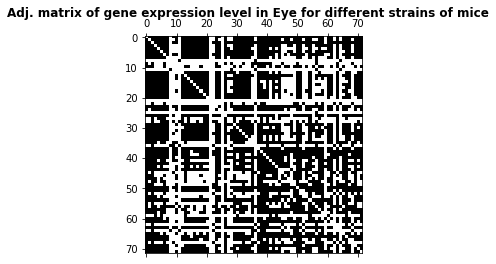

In [9]:
plt.spy(adjacency)
plt.suptitle("Adj. matrix of gene expression level in Eye for different strains of mice", fontweight='bold')
plt.show()

### Clustering

In [47]:
#first create the weighted adjacency

kernel_width = distances.mean()
weights_matrix = np.exp(-distances**2 / kernel_width**2)

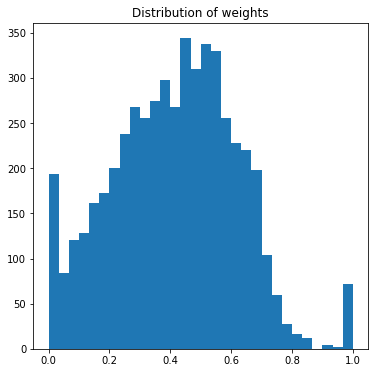

In [48]:
plt.figure(figsize=(6,6))
plt.hist(weights_matrix.flatten(),bins="auto")
plt.title('Distribution of weights')
plt.show()

In [49]:
#threshold 
weights_matrix[weights_matrix < 0] = 0


In [50]:
import networkx as nx
graph = nx.from_numpy_array(weights_matrix)

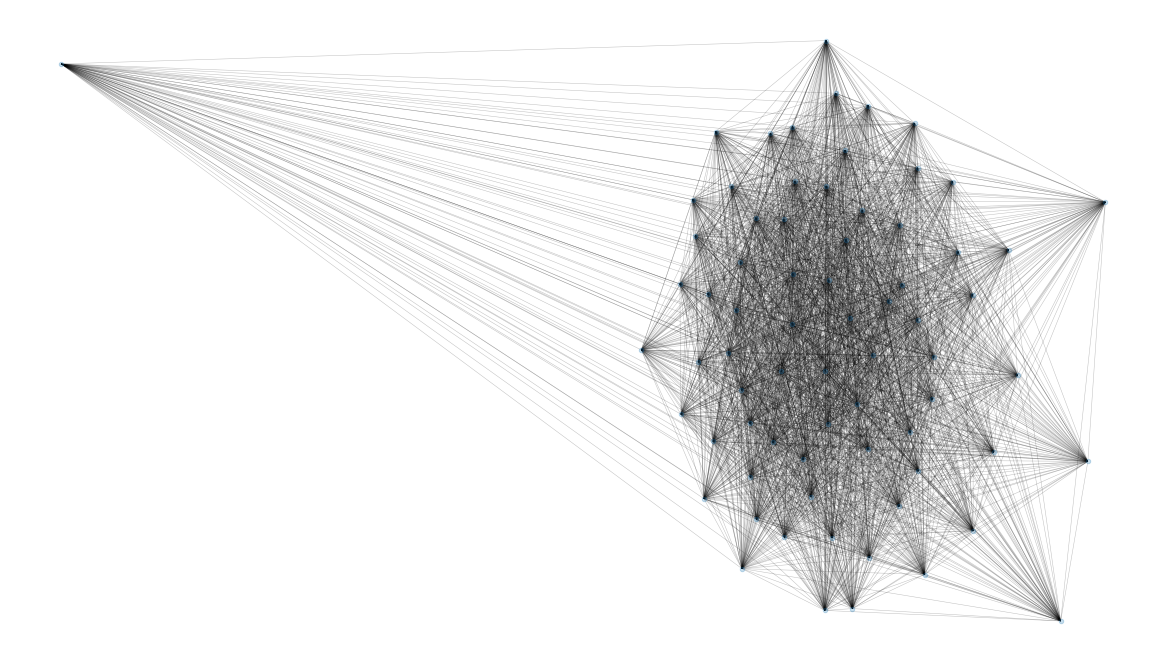

In [51]:
plt.figure(figsize=(16,9))

nx.draw(graph,node_size=20,width=0.5, alpha=0.25)

In [52]:
from tabulate import tabulate
def graph_basic_stats(G):
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()


    g_degree = G.degree()
    sum_degree = sum(dict(g_degree).values())
    average_degree = sum_degree / nodes_number

#     print("Number of nodes: %i" % nodes_number)
#     print("Number of edges: %i" % edges_number)
#     print(f"Graph density: {nx.classes.function.density(G) * 100:0.2f}%")
#     print(f"Average degree: {average_degree:0.2f}")
#     print(f"Number of connected components: {nx.number_connected_components(G)}")
#     print(f"Average clustering coefficient: {nx.average_clustering(G):0.2f}")
#     print(f"Diameter of the network (longest shortest path): {nx.diameter(G)}")

    tab = [
        ["Number of nodes", nodes_number],
        ["Number of edges", edges_number],
        ["Graph density", round(nx.classes.function.density(G) * 100, 2)],
        ["Average degree", round(average_degree, 2)],
        ["Number of connected components", nx.number_connected_components(G)],
        ["Average clustering coefficient", round(nx.average_clustering(G), 2)],
        ["Diameter of the network (longest shortest path)", nx.diameter(G)]   
    ]
    print(tabulate(tab, tablefmt='fancy_grid'))

In [53]:
graph_basic_stats(graph)

╒═════════════════════════════════════════════════╤═════════╕
│ Number of nodes                                 │   72    │
├─────────────────────────────────────────────────┼─────────┤
│ Number of edges                                 │ 2628    │
├─────────────────────────────────────────────────┼─────────┤
│ Graph density                                   │  102.82 │
├─────────────────────────────────────────────────┼─────────┤
│ Average degree                                  │   73    │
├─────────────────────────────────────────────────┼─────────┤
│ Number of connected components                  │    1    │
├─────────────────────────────────────────────────┼─────────┤
│ Average clustering coefficient                  │    1    │
├─────────────────────────────────────────────────┼─────────┤
│ Diameter of the network (longest shortest path) │    1    │
╘═════════════════════════════════════════════════╧═════════╛


### Feature selection and Classifier for Gene expressiond data


In [43]:
pheno.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [44]:
#Keep the color of the mice as label
y = pheno.loc["X62"].dropna()

#categorical label
y_cat = pd.get_dummies(y)

In [45]:
#to build adjacency matrix
genotype_df = geno.loc[:,y.index].T

In [46]:
#drop the coding gene of X62
#genotype_df = genotype_df.drop(["rs30336558","rs32862298"],axis=1)

In [47]:
genotype_df.shape

(90, 7324)

In [48]:
expression.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [49]:
dataset = expression.loc[:,y.index].T.fillna(0)

In [50]:
#Count number of nan for each gene.
nanByGene = expression.loc[:,y.index].isnull().sum(axis=1)

In [51]:
# keep only gene where there is less than 30 Nan // so more than 60 mice recorded.
mask = nanByGene < 30
maskedEx = expression.loc[mask,y.index]

In [52]:
maskedEx = maskedEx.T
med = maskedEx.median(axis=0)

In [53]:
med.values

array([11.093 , 10.0085,  8.607 , ...,  5.142 ,  5.391 ,  5.219 ])

In [54]:
#tiko imputation missing values

weighted_adj = adjacency_subset(genotype_df, genotype_df.index, 'cosine')
g = graphs.Graph(weighted_adj,"normalized")


def tikhonov_imputation(G, meas):
    """Impute missing values to a ndarray signal of shape (G.N, # of features)"""
    assert isinstance(G, graphs.Graph)
    assert isinstance(meas, np.ndarray)
    #assert meas.shape[0] == G.n_vertices
    
    # Init
    meas_copy = np.copy(meas)    
    imputed_array = np.zeros(meas.shape)
    val_mask = ~np.isnan(meas_copy)

    for idx in range(meas.shape[1]):
        
        if (idx%10000 == 0):
            print(idx,"/",meas.shape[1])
        imputed_array[:, idx] = learning.regression_tikhonov(G, meas_copy[:, idx], val_mask[:, idx], tau=0.1)
    
    imputed_array[val_mask] = meas[val_mask]
    # Verify consistancy
    assert (meas[val_mask] == imputed_array[val_mask]).all()
    return imputed_array

tikhonov_imputed_measures = tikhonov_imputation(g, np.array(maskedEx))

0 / 142600
10000 / 142600
20000 / 142600
30000 / 142600
40000 / 142600
50000 / 142600
60000 / 142600
70000 / 142600
80000 / 142600
90000 / 142600
100000 / 142600
110000 / 142600
120000 / 142600
130000 / 142600
140000 / 142600


In [55]:
tikhonov_imputed_measures.shape

(90, 142600)

In [62]:
maskedEx.tail()


gene,Nmt1_10338077,Psmb5_10338095,Hdac5_10338098,Dlg1_10338109,Wars_10338116,Psph_10338122,Copa_10338123,Tbl3_10338144,Gbf1_10338168,Hb1bp3_10338180,...,AFFX-r2-P1-cre-3_AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_AFFX-ThrX-3_at,AFFX-ThrX-5_AFFX-ThrX-5_at,AFFX-ThrX-M_AFFX-ThrX-M_at,Tfrc_AFFX-TransRecMur-X57349_3_at,Tfrc_AFFX-TransRecMur-X57349_5_at,Tfrc_AFFX-TransRecMur-X57349_M_at,AFFX-TrpnX-3_AFFX-TrpnX-3_at,AFFX-TrpnX-5_AFFX-TrpnX-5_at,AFFX-TrpnX-M_AFFX-TrpnX-M_at
BXD98,11.237,10.049,8.731,7.017,10.496,6.251,10.508,9.044,8.602,11.600,...,13.285,6.264,5.519,5.212,8.324,6.232,5.992,5.094,5.280,5.249
BXD99,11.333,10.712,8.254,5.660,9.827,5.577,9.569,9.066,7.877,11.442,...,13.391,6.358,5.475,5.184,8.232,6.226,6.192,5.098,5.468,5.322
BXD100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD101,10.870,9.966,9.119,7.230,9.735,6.175,9.926,8.750,8.325,11.279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD102,10.909,9.886,8.500,7.452,9.994,5.888,10.264,7.839,8.438,11.741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
maskedEx.mean()

gene
Nmt1_10338077                        11.082906
Psmb5_10338095                       10.034547
Hdac5_10338098                        8.572469
Dlg1_10338109                         5.841281
Wars_10338116                        10.014281
                                       ...    
Tfrc_AFFX-TransRecMur-X57349_5_at     6.478603
Tfrc_AFFX-TransRecMur-X57349_M_at     6.158794
AFFX-TrpnX-3_AFFX-TrpnX-3_at          5.140485
AFFX-TrpnX-5_AFFX-TrpnX-5_at          5.386294
AFFX-TrpnX-M_AFFX-TrpnX-M_at          5.219471
Length: 142600, dtype: float64

In [66]:
#fillna not working for all DF so column by column
for i,c in enumerate(maskedEx.columns):
    maskedEx.iloc[:,i].fillna(med.values[i], inplace=True)
    if i%10000==0:
        print(i)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


In [172]:
maskedExMedian = np.array(maskedEx).copy()

In [56]:
maskedExTik = tikhonov_imputed_measures.copy()

In [206]:
#features selection for median imputed dataset

In [173]:
#Select subset of 30 features based on mutual information
mi = mutual_info_classif(maskedExMedian,y)

#select top 30 features
top30Ind = np.argsort(mi)[::-1][:30]

top30MI = maskedExMedian[:,top30Ind]

In [174]:
#Select subset of 30 features based on RandomForest
clf = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(maskedExMedian, y_cat)

top30RFind = np.argsort(clf.feature_importances_)[::-1][:30]
top30RF = maskedExMedian[:,top30RFind]

In [175]:
#Select subset of 30 features based on Chi2

chi,_ = chi2(maskedExMedian,y_cat)
top30CHIind = np.argsort(chi)[::-1][:30]
top30CHI = maskedExMedian[:,top30CHIind]

In [207]:
#features selection for thikonov imputed dataset

In [205]:
#Select subset of 30 features based on mutual information
miTik = mutual_info_classif(maskedExTik,y)

#select top 30 features
top30IndTik = np.argsort(mi)[::-1][:30]

top30MITik = maskedExTik[:,top30Ind]

In [208]:
#Select subset of 30 features based on RandomForest

clfTik = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)

# Train the classifier
clfTik.fit(maskedExTik, y_cat)

top30RFind = np.argsort(clfTik.feature_importances_)[::-1][:30]
top30RFTik = maskedExTik[:,top30RFind]

In [232]:
#Select subset of 30 features based on Chi2

chiTik,_ = chi2(maskedExMedian,y_cat)
top30CHIindTik = np.argsort(chi)[::-1][:30]
top30CHITik = maskedExMedian[:,top30CHIind]

In [176]:
def NN(n_x, n_h1, n_h2, dropout, num_classes):
    model = Sequential()
    model.add(Dense(n_h1, input_dim=n_x, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n_h2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [177]:
class Net(nn.Module):
    def __init__(self, num_feats, h1, h2, drop, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_feats,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,num_classes)
        self.Dropout = nn.Dropout(drop)
    
    def forward(self,x):
        x = self.Dropout(F.relu(self.fc1(x)))
        x = self.Dropout(F.relu(self.fc2(x)))
        return self.fc3(x)
    

def train(model, batchs, epochs, loss_fcn, optimizer):
    
    losses_ = []

    for epoch in range(epochs):
        model.train(True)
        
        batch_loss = []
        for batch in batchs:
            features, labels = batch
            
            optimizer.zero_grad()
            logits = model(features.float())
            loss = loss_fcn(logits,labels)
            
            #custom l1 reg
            l1 = 0
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
            
            loss = loss + 0.001*l1
            
            loss.backward()
            #print(model.fc3.weight.grad)
            optimizer.step()
            batch_loss.append(loss)
        
        losses_.append(th.mean(th.stack(batch_loss)))
        #print(torch.mean(torch.stack(batch_loss)))
    return th.mean(th.stack(losses_))

def evaluate(model, features, labels):
    model.eval()
    
    with th.no_grad():
        logits = model(features.float())
        _, indices = th.max(logits,dim=1)
        correct = th.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels)
        
        return acc
        

In [178]:
#CV
from sklearn.model_selection import KFold, StratifiedShuffleSplit, train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

#cst variables initialization
num_feats = top30RF.shape[1]
h1 = 128
h2 = 64
num_classes = 4
dropout = 0.5
epochs = 1000
lr = 0.001 #default for keras and pytorch 
#betas = (0.9,0.999) default for keras and pytorch


callback = EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
kf = KFold(n_splits=5,shuffle=True)
#kf = StratifiedShuffleSplit(n_splits=5)
subset_accs = []
subset_stds = []
subsets_ = [top30RF, top30MI, top30CHI]
subset_accs_tr = []
subset_stds_tr = []

for subset in subsets_:

    print("newSubset")
    val_accs = []
    tr_accs = []
    
    for trIndex, valIndex in kf.split(subset):
        print("newFold")
        
        #sample a normalized fold
        mm = MinMaxScaler()
        tr, val = mm.fit_transform(subset[trIndex,:]), mm.transform(subset[valIndex,:])
        tr_label , val_label = y_cat.iloc[trIndex,:], y_cat.iloc[valIndex,:]
        
        ##Pytorch // convert to tensor
        tr, val = th.tensor(tr),th.tensor(val)
        tr_label , val_label = th.LongTensor(tr_label.values),th.LongTensor(val_label.values)
        
        #convert label to indices specific to pytorch CrossEntropyLoss
        tr_label = np.argmax(tr_label,axis=1)
        val_label = np.argmax(val_label, axis=1)

        ##generate batch
        tr_set = TensorDataset(tr, tr_label)
        val_set = TensorDataset(val, val_label)
        tr_batchs= DataLoader(tr_set,batch_size=10,shuffle=True,drop_last=False)
        #val_batchs=torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=False)

        model = Net(num_feats,h1, h2, dropout, num_classes)
        loss_fcn = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters(), lr=lr)
        loss = train(model,tr_batchs, epochs, loss_fcn,optimizer)
        tr_accs.append(evaluate(model,tr,tr_label))
        val_accs.append(evaluate(model,val,val_label))
        
        #Keras
        #nn = NN(num_feats, h1, h2, dropout, num_classes)
        #nn.fit(tr, tr_label, epochs=epochs, verbose=0, callbacks=[callback])
        #val_accs.append(nn.evaluate(val, val_label)[1])
        #tr_accs.append(nn.evaluate(tr, tr_label)[1])
    
    subset_accs.append(np.mean(val_accs))
    subset_accs_tr.append(np.mean(tr_accs))
    subset_stds.append(np.std(val_accs))
    subset_stds_tr.append(np.std(tr_accs))

newSubset
newFold
newFold
newFold
newFold
newFold
newSubset
newFold
newFold
newFold
newFold
newFold
newSubset
newFold
newFold
newFold
newFold
newFold


In [179]:
for subset, acc, acc_tr, std, std_tr in zip(["RF","MI","Chi2"], subset_accs, subset_accs_tr, subset_stds, subset_stds_tr):
    print("Feature selection method ",subset,":", np.round(acc,3),"±",np.round(std,3),"% of val. accuracy and",np.round(acc_tr,3),"±",np.round(std_tr,3),"% of tr. accuracy")

Feature selection method  RF : 0.822 ± 0.074 % of val. accuracy and 0.897 ± 0.024 % of tr. accuracy
Feature selection method  MI : 0.811 ± 0.09 % of val. accuracy and 0.883 ± 0.019 % of tr. accuracy
Feature selection method  Chi2 : 0.789 ± 0.124 % of val. accuracy and 0.914 ± 0.01 % of tr. accuracy


### Graph

In [1214]:
import time
from helper import *
from utils import *
import matplotlib.pyplot as plt
import networkx as nx
import dgl.function as fn
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

In [1071]:
data = citegrh.load_cora()

G = DGLGraph(data.graph)
coralabels = th.tensor(data.labels)

In [1079]:
datatest =  data.features[:,:30]
weighted_adj = torch.tensor(G.adjacency_matrix().clone().detach().to_dense())

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [200]:
#Select dataset and create mask for train/teat/validation
subset = subsets_[1] #RF

mm = MinMaxScaler()
norm_subset = mm.fit_transform(subset)
features, labels = th.tensor(norm_subset), th.LongTensor(y_cat.values)
labels = np.argmax(labels,axis=1)

#cora test
#features = torch.tensor(datatest)
#labels = torch.LongTensor(coralabels)
#print(features.shape,labels.shape)

#Startified Split the data into train/test
from sklearn.utils import shuffle
ind_0 = np.where(labels==0)[0][:12]
ind_1 = np.where(labels==1)[0][:12]
ind_2 = np.where(labels==2)[0][:12]
ind_3 = np.where(labels==3)[0][:12]

train_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
valTest_mask = [i for i in range(len(labels)) if i not in train_mask]

ind_0 = np.where(labels==0)[0][12:12+9]
ind_1 = np.where(labels==1)[0][12:12+6]
ind_2 = np.where(labels==2)[0][12:12+3]
ind_3 = np.where(labels==3)[0][12:12+4]

val_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
print(valTest_mask,val_mask)
test_mask = [i for i in valTest_mask if i not in val_mask]


## Split the data into train / test / validation
#test_p = 0.20
#val_p = 0.20
#test_size = int(len(labels)*test_p)
#val_size = int((len(labels) - test_size) * val_p)
#random_idx = th.randperm(len(labels))
#not_test_mask = random_idx[test_size:]
#
#
## Test mask
#test_mask = random_idx[:test_size]
#
## Train masks
#train_random_idx = th.randperm(len(not_test_mask))
#train_mask = not_test_mask[train_random_idx[val_size:]]
#val_mask = not_test_mask[train_random_idx[:val_size]]


print("train_size: %i | test_size: %i | val_size: %i" % (len(train_mask), len(test_mask), len(val_mask)))



[33, 39, 40, 41, 42, 46, 48, 50, 53, 54, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89] [60, 61, 63, 64, 65, 67, 69, 72, 73, 48, 50, 53, 54, 56, 58, 33, 40, 68, 39, 41, 42, 46]
train_size: 48 | test_size: 20 | val_size: 22


In [1642]:
#proportion of class in train
pd.Series(labels[train_mask]).value_counts(),pd.Series(labels[val_mask]).value_counts()

(3    12
 2    12
 1    12
 0    12
 dtype: int64, 0    9
 1    6
 3    4
 2    3
 dtype: int64)

(90, 7324)


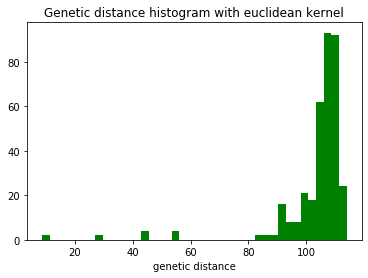

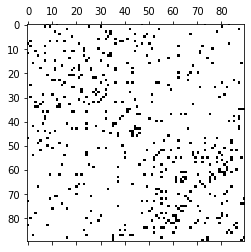

In [87]:
#build adjacency based on genetic strains
print(genotype_df.shape)
genetic_distance_w, idx = distance_scipy_spatial(genotype_df.values, k=4, metric='euclidean')
weighted_adj = adjacency(genetic_distance_w, idx)
weighted_adj = th.tensor(weighted_adj.todense())


# Plot the genetic strains distance histogram
ax = plt.subplot()
plt.title("Genetic distance histogram with euclidean kernel")
plt.xlabel("genetic distance")
plt.hist(genetic_distance_w.flatten(), bins=40, color='g')
plt.show()
plt.spy(weighted_adj.todense())

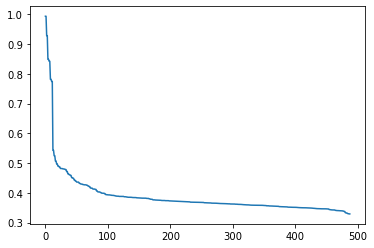

6.02 % of the original data is kept


In [88]:
plot_distrib(weighted_adj.toarray())
plt.show()
print_remaining_data(weighted_adj.toarray())

In [99]:
class GraphLayer(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.LeakyReLU(0.6,True)):
        super(GraphLayer, self).__init__()
        fc = [nn.Linear(in_features, out_features)]
        if activation is not None:
            fc.append(activation)
        self.fc = nn.Sequential(*fc)
        
    def forward(self, A, x):
        """See randomWalk function to better understand as A was modified"""
        #Weighted average of neighbours's features.
        y = th.mm(A, x)
        
        return self.fc(y)

In [101]:
class GNN(nn.Module):
    def __init__(self, num_feats, h1, h2, drop, num_classes):         
        super(GNN, self).__init__()
        self.gl1 = GraphLayer(num_feats,h1)
        self.gl2 = GraphLayer(h1,h2)
        self.fc3 = nn.Linear(h2, num_classes)
        self.Dropout = nn.Dropout(drop)

    def forward(self, A, x):
        x = self.Dropout(self.gl1(A,x))
        x = self.Dropout(self.gl2(A,x))
        return self.fc3(x) 

In [103]:
def randomWalk(A, max_path=4, max_n=4):
    """Not actually a randomWalk but the idea is the same;
    Take only in account "max_n" randomly chosen neighbours of degree <= "max_path",
    weighted by the edge(s) in between.
    (degree == how many step from initial node to get to neighbour)"""
    
    A_1 = A.float() + th.eye(A.shape[0])
    A_n = F.normalize(A_1, p=1, dim=1)

    A_4 = np.linalg.matrix_power(A_n,max_path)
    
    for i in range(A.shape[1]):

        ind_non_empty = np.where(A_4[i,:] > 0)[0]
        
        if len(ind_non_empty) < max_n:
            select_ind = ind_non_empty
        else:

            select_ind = list(np.random.choice(ind_non_empty,max_n))

        
        select_ind = np.append(select_ind,i)
        A_4[i,~select_ind] = 0

    A_4t = th.tensor(A_4)
    A_nn = F.normalize(A_4t.float(), p=1, dim=1)
        
    return A_nn

In [238]:
def train(model, A, batchs, loss_fcn, train_mask, optimizer, n_neigh):
    model.train()  # Activate dropout
    
    losses_ = []
    real_batchs = 32
    for i in range(real_batchs):
        
        A_nn = randomWalk(A,2,n_neigh)
        
        for batch in batchs:

            features, labels = batch
            
            optimizer.zero_grad()

            logits = model(A_nn, features.float())
            loss = loss_fcn(logits[train_mask], labels[train_mask])

            loss.backward()
            optimizer.step()

            losses_.append(loss)
        
    return th.mean(th.stack(losses_))

def evaluate(model, A, features, labels, mask, n_neigh):
    model.eval()  # Deactivate dropout
    with th.no_grad():
        real_batchs = 32
        corrects = 0
        labels = labels[mask]
        mc_ = []
        for i in range(real_batchs):
            A_nn = randomWalk(A,2,n_neigh)
    
            logits = model(A_nn, features.float())[mask]  # only compute the evaluation set
            _, indices = th.max(logits, dim=1)
            corrects = corrects + th.sum(indices == labels)
            mc_.append(mc(labels,indices))
            
        return corrects.item() * 1.0 / (len(labels)*real_batchs),  np.sum(mc_)/real_batchs

In [299]:
import time

dur = []
accs_ = []
subsets_ = [[top30RF, top30MI, top30CHI],[top30RFTik, top30MITik, top30CHITik]]
names = ["median","thikonov"]
subnames = ["RF","MI","CHI2"]
max_neighbours = [1,3,5,10]
max_trials = 10

WholeResults = {}

#imputing method
for mname, methodsubset in zip(names,subsets_):
    
    WholeResults[mname] = {}
    
    #Subsets derived from diff. Features Selection Methods
    for subname, subset in zip(subnames, methodsubset):
        
        WholeResults[mname][subname] = {}
        mm = MinMaxScaler()
        norm_subset = mm.fit_transform(subset)
        features, labels = th.tensor(norm_subset), th.LongTensor(y_cat.values)
        labels = np.argmax(labels,axis=1)

        model = GNN(num_feats,64, 32, 0.5, 4)
        loss_fcn = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters(), lr=0.01)
        dataset = TensorDataset(features, labels)
        batchs = DataLoader(dataset,batch_size=90,shuffle=False,drop_last=False)

        #Test diff. # of neighbours
        for n in max_neighbours:
            print("new neigh:", n)
            neighname = "N" + str(n)
            WholeResults[mname][subname][neighname] = {}
            WholeResults[mname][subname][neighname]["train"] = {}
            WholeResults[mname][subname][neighname]["validation"] = {}
            WholeResults[mname][subname][neighname]["test"] = {}
            
            trials_results = np.zeros((max_trials,6))
            
            #Multiple Trials to get more robust results
            for t in range(max_trials):
                print("trial: ", t,"/",max_trials)
                
                results_ = np.zeros((15,4))
                for epoch in range(15):

                    loss = train(model, weighted_adj, batchs, loss_fcn, train_mask, optimizer, n)

                    val_acc, val_mcc = evaluate(model, weighted_adj, features, labels, val_mask, n)
                    tr_acc, tr_mcc = evaluate(model, weighted_adj, features, labels, train_mask, n)
                    results_[epoch,:] = [tr_acc, tr_mcc, val_acc, val_mcc]
                
                te_acc, te_mcc = evaluate(model, weighted_adj, features, labels, test_mask, n)
                trials_results[t,:] = [*results_.mean(axis=0),te_acc,te_mcc]
            
            
            #save all in dico WholeResults
            subdico_train = WholeResults[mname][subname][neighname]["train"]
            subdico_validation = WholeResults[mname][subname][neighname]["validation"]
            subdico_test = WholeResults[mname][subname][neighname]["test"]
            subdico_train["acc"],subdico_train["mcc"] = trials_results[:,:2].mean(axis=0) 
            subdico_validation["acc"],subdico_validation["mcc"] = trials_results[:,2:4].mean(axis=0) 
            subdico_test["acc"],subdico_test["mcc"] = trials_results[:,-2:].mean(axis=0)                    
                                       

new neigh: 1
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 3
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 5
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 10
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 1
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 3
trial:  0 / 10
trial:  1 / 10
trial:  2 / 10
trial:  3 / 10
trial:  4 / 10
trial:  5 / 10
trial:  6 / 10
trial:  7 / 10
trial:  8 / 10
trial:  9 / 10
new neigh: 5
trial:  

In [301]:
to_plot_acc = np.zeros((3,len(max_neighbours)))
to_plot_mcc = np.zeros((3,len(max_neighbours)))
for i,s in enumerate(subnames):
    for j,n in enumerate(WholeResults["median"][s].keys()):
        to_plot_acc[i,j] = WholeResults["median"][s][n]["test"]["acc"]
        to_plot_mcc[i,j] = WholeResults["median"][s][n]["test"]["mcc"]

to_plot_acc_imp = np.zeros((3,len(max_neighbours)))
to_plot_mcc_imp = np.zeros((3,len(max_neighbours)))
for i,s in enumerate(subnames):
    for j,n in enumerate(WholeResults["thikonov"][s].keys()):
        to_plot_acc_imp[i,j] = WholeResults["thikonov"][s][n]["test"]["acc"]
        to_plot_mcc_imp[i,j] = WholeResults["thikonov"][s][n]["test"]["mcc"]

    
print(to_plot_acc.flatten())
print(to_plot_acc_imp.flatten())

[0.60875    0.59890625 0.6009375  0.59046875 0.600625   0.594375
 0.5875     0.56515625 0.544375   0.5234375  0.51671875 0.52265625]
[0.65203125 0.68671875 0.655      0.65953125 0.59609375 0.630625
 0.615      0.62       0.5334375  0.523125   0.50390625 0.51625   ]


#### Unbalanced labels
pd.Series(labels).value_counts()/len(labels)

In [1181]:
df_labels = pd.Series(labels, index=subsets_[0].index)

In [1183]:
pd.concat([subsets_[0], genotype_df, df_labels], axis=1).to_csv("SetForWCGAN.csv")

In [1184]:
pd.concat([subsets_[0], genotype_df, df_labels], axis=1)

,Tmod3_1455708_at,Tmod3_1438556_a_at,Ptprd_1443053_at,C920006O11Rik_1435704_at,Ptprd_1442837_at,Mela_1456182_x_at,Ptprd_1440624_at,Mela_10582549,Ptprd_1443056_at,Myo5a_1431320_a_at,...,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461,0
BXD1,10.689,6.928,6.314,5.842,4.715,8.124,4.946,13.4730,7.940,9.796,...,-1,-1,-1,-1,-1,1,1,1,-1,0
BXD2,9.202,6.822,7.113,7.332,5.044,4.894,7.579,6.8750,8.376,10.498,...,-1,-1,-1,-1,-1,1,1,1,-1,3
BXD5,10.853,6.852,7.763,6.581,5.482,7.746,6.913,8.0380,8.190,9.847,...,-1,-1,-1,-1,-1,1,1,1,-1,2
BXD6,10.865,7.056,7.075,5.987,4.956,7.880,7.300,8.4850,8.586,9.786,...,1,1,1,1,1,1,1,1,-1,2
BXD8,10.930,7.335,7.183,5.774,5.268,7.855,7.797,8.5540,8.284,10.082,...,-1,-1,-1,-1,-1,1,1,1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BXD98,10.984,7.200,6.663,5.900,4.831,7.775,5.102,8.8810,7.976,9.639,...,1,1,1,1,1,1,1,1,-1,0
BXD99,10.488,7.344,6.794,5.660,4.839,7.902,5.172,7.9220,8.131,9.984,...,1,1,1,1,1,1,1,1,1,0
BXD100,10.521,6.891,6.950,5.973,4.926,7.634,5.256,8.1255,8.242,9.988,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
BXD101,10.521,6.891,6.950,5.973,4.926,7.634,5.256,8.1250,8.242,9.988,...,1,1,1,1,1,1,1,1,-1,2
